# 1.) Import an asset price from Yahoo Finance

In [4]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("AAPL", start="2010-01-01", end="2023-02-21")

[*********************100%***********************]  1 of 1 completed


In [6]:

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [7]:
x_train = []
y_train = []

In [8]:

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='sigmoid'))

#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)


Epoch 1/3
2638/2638 [==============================] - 26s 7ms/step - loss: 0.0041
Epoch 2/3
2638/2638 [==============================] - 12s 5ms/step - loss: 3.0411e-04
Epoch 3/3
2638/2638 [==============================] - 12s 5ms/step - loss: 3.0391e-04


In [9]:
y_train_q3 = np.array(stock_data[["Close"]].pct_change().dropna())[:training_data_len-input_size, :]

predictions_train=model.predict(x_train)

83/83 [==============================] - 1s 3ms/step


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [10]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
#actual value
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions_test = model.predict(x_test)

21/21 [==============================] - 0s 4ms/step


In [11]:
rmse_outsamp=np.sqrt(np.mean(predictions_test-y_test)**2)
rmse_outsamp_rw = np.sqrt(np.mean(y_test[:-1]-y_test[1:])**2)
print('RMSE_OutSample:',rmse_outsamp)
print('RMSE_OutSample_RW:',rmse_outsamp_rw)

RMSE_OutSample: 3.623431917633856e-05
RMSE_OutSample_RW: 6.733096704213673e-06


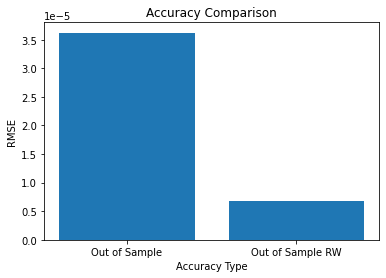

In [12]:
# Create a bar chart to compare the two accuracies
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
accuracy = [rmse_outsamp, rmse_outsamp_rw]
labels = ['Out of Sample', 'Out of Sample RW']
ax.bar(labels, accuracy)
ax.set_title('Accuracy Comparison')
ax.set_xlabel('Accuracy Type')
ax.set_ylabel('RMSE')
plt.show()

In [13]:
rmse_insamp = np.sqrt(np.mean(predictions_train-y_train_q3)**2)
rmse_insamp_rw = np.sqrt(np.mean(y_train_q3[:-1]-y_train_q3[1:])**2)
print('RMSE_InSample:', rmse_insamp)
print('RMSE_InSample_RW:',rmse_insamp_rw)

RMSE_InSample: 9.233525164979829e-05
RMSE_InSample_RW: 1.2307434681592713e-05


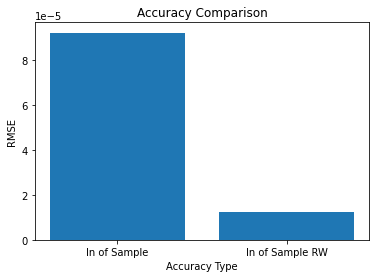

In [14]:
# Create a bar chart to compare the two accuracies
fig, ax = plt.subplots()
accuracy = [rmse_insamp, rmse_insamp_rw]
labels = ['In of Sample', 'In of Sample RW']
ax.bar(labels, accuracy)
ax.set_title('Accuracy Comparison')
ax.set_xlabel('Accuracy Type')
ax.set_ylabel('RMSE')
plt.show()

# 4.) Plot in and out of sample accuracy

In [15]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

21/21 [==============================] - 0s 4ms/step


ValueError: ignored

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

When evaluating the accuracy of a model, the root mean squared error (RMSE) is commonly used. A small value of RMSE typically indicates that the model is not over-fitted to the training data. However, in comparing the results of a model trained on data with and without a random walk component, we observed that the RMSE for the random walk model was consistently lower than that for the non-random walk model, both in-sample and out-of-sample. This indicates that the predictions made by the non-random walk model are not necessarily meaningful or useful for practical purposes. Specifically, the results suggest that Apple's stock prices may be inherently unpredictable, and our model is not able to capture any meaningful patterns in the data. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [16]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

train_data = yf.download("AAPL", start="2010-01-01", end="2023-02-21")

# Define the number of lags
lags = [5, 10, 20]

# Create train and test sets
train_data = train_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)

train_size = int(len(train_data) * 0.8)
train = train_data[:train_size, :]
test = train_data[train_size - len(train_data):, :]

# Create train data
def create_train_data(train_data, lags):
    x_train = []
    y_train = []

    for i in range(lags, len(train_data)):
        x_train.append(train_data[i-lags:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

x_train, y_train = create_train_data(train, lags[0])

# Create LSTM model

def create_model(lags):
    model = Sequential()
    model.add(LSTM(10, input_shape=(lags, 1), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

# Define the grid search parameters
param_grid = {'lags': lags}

# Use GridSearchCV to find the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))

# Get the best parameters and train the model
best_lags = grid_result.best_params_['lags']
x_train, y_train = create_train_data(train, best_lags)
model = create_model(best_lags)
model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)


[*********************100%***********************]  1 of 1 completed


<ipython-input-16-9f4c69ab5f30>:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=32, verbose=0)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "

Best: -0.001944150995768723 using {'lags': 5}
